 ## collaborators

- Donghun Lee, donghunlee@g.harvard.edu
- Ismail Ben Atitallah, benatitallah@g.harvard.edu
- we agree to receive the same grade


# Q1: GLMs with correlation

In [0]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from theano import tensor as tt
from pprint import pprint
%matplotlib inline


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [0]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset['category'] = dataset['category']-1 #zero indexing
dataset

,category,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

### answer

The upgraded model has been implemented. We referred to the sample code shared.

In [0]:
import pymc3 as pm

In [0]:
# observed data
n = dataset['total']
x = dataset['sex']
y_obs = dataset['>50']

sample_size = 10000
tune_param = 2000
burnin = 500

In [0]:
# Income classification model education and gender
with pm.Model() as parta_model:
    
    # priors -- one per education category
    alpha = pm.Normal('alpha', 0, 10)
    beta_m = pm.Normal('beta_m', 0, 1)
    sigma = pm.HalfCauchy("sigma", 2)
    alphas = pm.Normal('alphas', alpha, sigma, shape=7)
    # define likelihood    
    # create an invLogit on the category in each row of our data i.e. [0, 0, 1, 1, 2, 2 ... 6, 6]
    # add in gender effects
    log_odds = pm.Deterministic("log_odds", alphas[np.arange(14)//2] + beta_m * x)
    p = pm.math.invlogit(log_odds)
    
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)

**A2**: You will notice here that the $\alpha$s at different income levels are pooled

### 1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data?

### answer:

In choosing the level of pooling, there are two main aspects to consider, in terms of bias-variance composition. The first factor to consider is the underlying dependence/correlation between random variables we are aimining to model. The second is the bias-variance tradeoff. To take the given problem for example, it is reasonable to expect the 7 education levels have some amount of information inherent in them shared. In this case, pooling would likely be beneficial. On the other hand, if we were to model vastly different things, pooling would not be a sensible choice. Full pooling would be appropriate if we were to model almost identical objects. Naturally partial pooling would be sensible when there is correlation but also characteristics unique to each object. Full pooling may underfit data with high bias, if we were to model for vastly different objects. No pooling might overfit data with high variance. Partial pooling, when the balance is struck correctly, may help prevent overfitting or underfitting.      


### 2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

### answer:

Partial pooling is implemented here because we modeled each education level with distinct parameters but imposed a prior for each. It is appropriate because it is reasonable to expect correlation/dependence among education categories. In addition, since we have relatively small amounts of data for certain categories like Phd, partial pooling may be a sensible choice.That said, it is worth noting we used one fixed $\beta_m$ for all gender categories.   


**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

### answer:

10,000 samples were sampled with tune_param=2000 and burnin=500. We show three diagnostics: traceplot to show autocorrelation, geweke test amd gellman-rubin test for convergence. The traceplot looks fine because the autocorrelation shown on the right-side panels show good coverage. In terms of geweke tests, we see the dots line up which show a sign of convergence. In terms of gelman_rubin, we see values all close to 1.0 which is an indicator of convergence. 

In [0]:
with parta_model:
    parta_trace = pm.sample(sample_size, tune=tune_param, nchains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, sigma_log__, beta_m, alpha]
100%|██████████| 12000/12000 [00:12<00:00, 952.12it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4da4a52e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff4da2dab38>]], dtype=object)

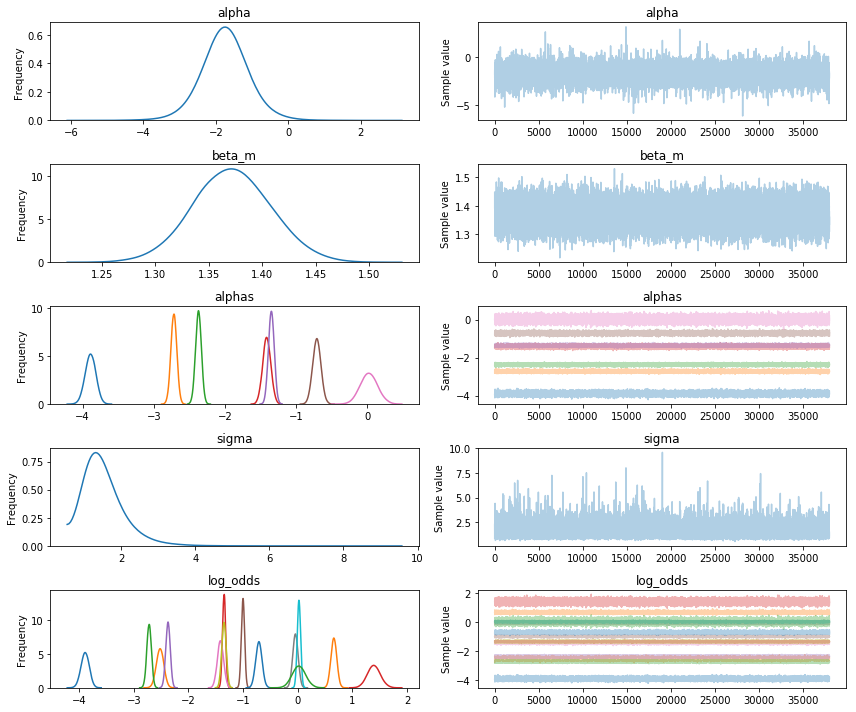

In [0]:
pm.traceplot(parta_trace[burnin:], combined=True)

(0, 13000)

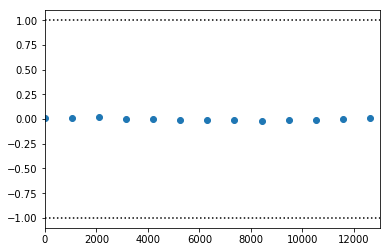

In [0]:
# gwaeke
from pymc3 import geweke
    
z = geweke(parta_trace["alphas"])
#plt.scatter(z[:,0],z[:,1])
plt.scatter(*z[0].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

# gellman rubin

(0, 13000)

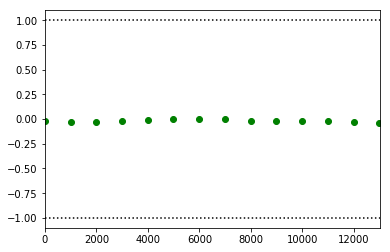

In [0]:
# gwaeke
from pymc3 import geweke
    
z = geweke(parta_trace[burnin:]["beta_m"])
plt.scatter(z[:,0],z[:,1], c="green")
#plt.scatter(*z[0].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

# gellman rubin

In [0]:
from pymc3 import gelman_rubin
from pprint import pprint 
pprint(gelman_rubin(parta_trace[burnin:]))


{'alpha': 0.9999750493485795,
 'alphas': array([ 0.99998136,  1.0002342 ,  1.00007457,  1.00007092,  1.00013255,
        1.00001979,  1.00008933]),
 'beta_m': 1.0001918230258235,
 'log_odds': array([ 0.99998136,  0.99997785,  1.0002342 ,  0.99997259,  1.00007457,
        0.999996  ,  1.00007092,  0.99997766,  1.00013255,  0.99995854,
        1.00001979,  1.00006092,  1.00008933,  1.00001036]),
 'sigma': 1.0001137550726176}


**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

### answer

We compare the empirical log odds and posterior log odds in terms of gender for each education level. The shrinkage plot has been plotted as below.

In [0]:
def shrinkage_plot(observed_log_odds, posterior_alpha_means, posterior_alpha_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label="Observed Log Odds", color='orange')
    plt.errorbar(range(len(posterior_alpha_means)), posterior_alpha_means, yerr = 2*posterior_alpha_sds, fmt='o', label="Posterior for Log Odds\n(mean and 2 SDs)",)
    plt.legend()
    plt.xlabel("Education Category")

In [0]:
observed_p = dataset[">50"] / dataset["total"]
observed_log_odds = np.log(observed_p / (1 - observed_p))
observed_log_odds_m = observed_log_odds.iloc[1::2]
observed_log_odds_f = observed_log_odds.iloc[::2]

In [0]:
gender_trace=education_gender_trace[burnin:]
gender_alphas = gender_trace['alphas']
gender_beta = gender_trace['beta_m']

males = gender_alphas + np.vstack(gender_beta)
females = gender_alphas
diff = males - females
print('Male advantage percentiles', np.percentile(diff, 2.5), np.percentile(diff, 50), np.percentile(diff, 97.5))

Male advantage percentiles 1.30072309898 1.37116462768 1.44160946149


In [0]:
posterior_means_m = males.mean(axis=0)
posterior_stds_m = males.std(axis=0)
posterior_means_f = females.mean(axis=0)
posterior_stds_f = females.std(axis=0)

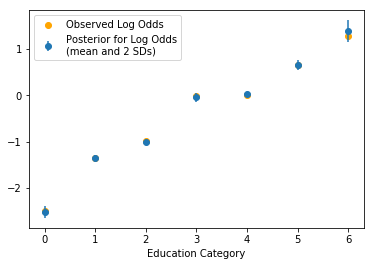

In [0]:
shrinkage_plot(observed_log_odds_m, posterior_means_m, posterior_stds_m)

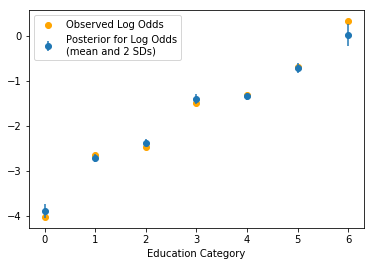

In [0]:
shrinkage_plot(observed_log_odds_f, posterior_means_f, posterior_stds_f)

**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

### answer
To see the effect of pooling, we compare the observed log odds to the posterior means of log odds for each gender. We observe very little shrinkage for each gender and almost all education levels, except the last one. One likely reason we see minimal shrinkage, as opposed to what we had seen in McElreath's new model, is that we have more observations for most of the categories -except the last one- in this income data than in the McElreath's data. In our example, due to the larger amount of samples, the joint likelihood term dominates, except in the last category. As we commented on the effect of pooling when data size is small in A1, the noticeable fact about the last category is that the number of total observations for female is 86 and for male 327, which explains why the shrinkage is more pronouced for female than for male. For the last category, the number is significantly low compared to other education levels, and therefore the effect of pooling is more pronounced. Moreover, the standard error plotted with the line is sufficiently large to include the estimates given by the observed log odds. Since both standard error and shrinkage depend on the number of data points: the larger data amounts, the less shrinkage and standard error. We confirm the relationship in the plots above where we have small standard error with minimal shrinkage for the first 5 categories as they have more data than the last category which show the substantial shrinkage with high standard error due to low amount of data.  



## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).


### answer

We implemented the model in 13.2.2 by adapting the code made available in the link in the problem statement. We removed unncessary parts and adapted a bit.


In [0]:
with pm.Model() as partb_model:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
        
    mu = pm.MvNormal('ab_cafe', mu=tt.stack([a, bm]), chol=chol, shape=(7, 2))
    a_edu = pm.Deterministic('a_edu', mu[:, 0])
    bm_edu = pm.Deterministic('bm_edu', mu[:, 1])
    

    p = pm.Deterministic("p", pm.math.invlogit(mu[np.arange(14)//2, 0] + mu[np.arange(14)//2, 1] * x))
    
    admit = pm.Binomial('income', p=p, n=n, observed=y_obs)
    

In [0]:
with partb_model:
    sample_size = 20000
    partb_trace = pm.sample(sample_size, tune=tune_param, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_cafe, chol_cov_cholesky_cov_packed__, bm, a]
100%|██████████| 22000/22000 [03:19<00:00, 110.13it/s]
There were 2969 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.627149692681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2091 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.677246328127, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718012412303, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1826 divergences after tuning. Increase `target_accept` or

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4d9479c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff4f44057b8>]], dtype=object)

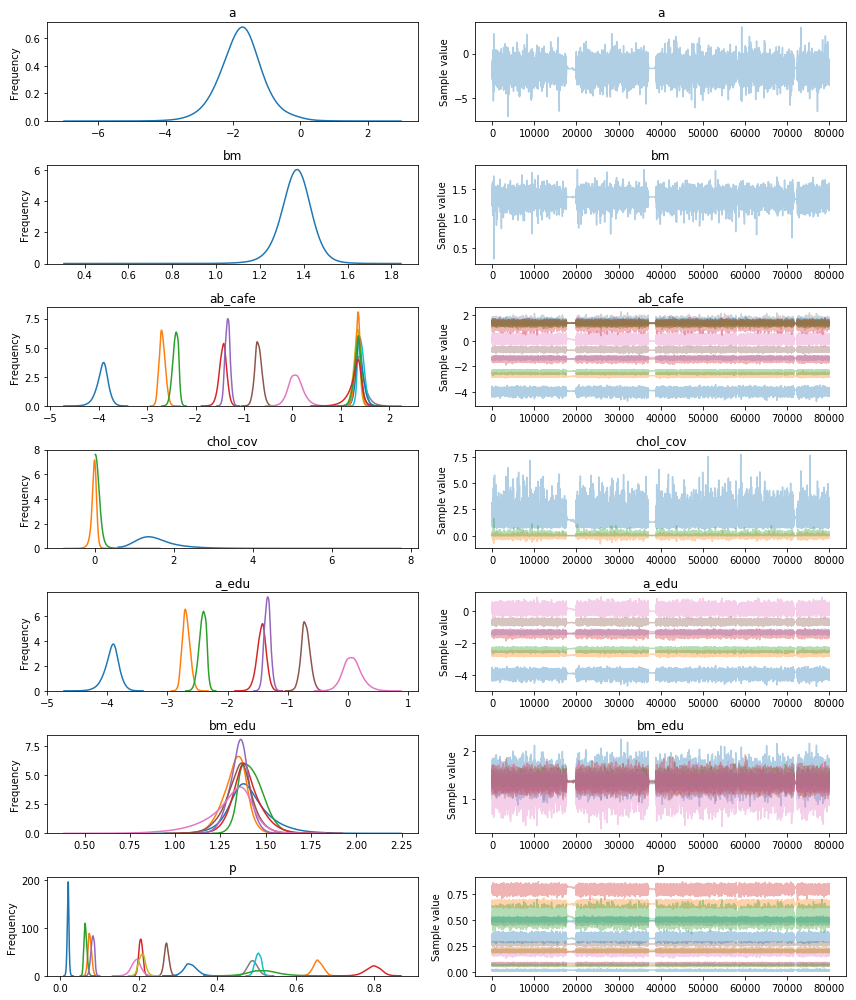

In [0]:
#partb_trace = partb_trace[burnin:]
pm.traceplot(partb_trace, combined=True)

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.


### answer

We sampled 20,000 points with the model with target acceptance rate of 0.9. Just like before, we used traceplot, gweke test, and gellman-rubin test. As shown in the warning messages of the sampling step and some parts of the traceplot, there's a problem in the quality of samples regarding convergence. In terms of gweke tests, the divergence issue is not extremely clear as the means are lining up. In terms of gellman rubin, also the issue of divergence is not dramatic either, as the values are close to 1.0. 


(0, 13000)

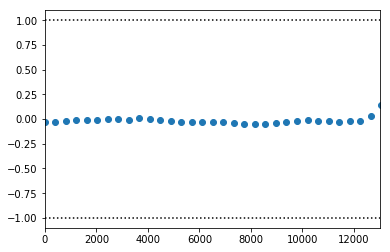

In [0]:
# gwaeke
from pymc3 import geweke
    
z = geweke(partb_trace["a_edu"], intervals=50)
#plt.scatter(z[:,0],z[:,1])
plt.scatter(*z[0].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

# gellman rubin

(0, 13000)

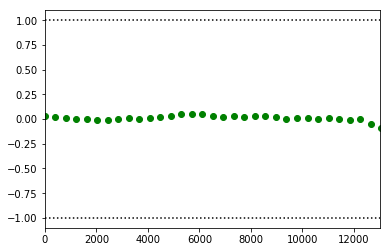

In [0]:
# gwaeke
from pymc3 import geweke
    
z = geweke(partb_trace['bm_edu'], intervals=50)
plt.scatter(*z[0].T, color="green")
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

# gellman rubin

In [0]:
from pymc3 import gelman_rubin
from pprint import pprint 
pprint(gelman_rubin(partb_trace))


{'a': 1.0010033546677906,
 'a_edu': array([ 1.00063359,  1.00015547,  1.00064391,  0.99999297,  1.0000849 ,
        1.00165716,  1.00008485]),
 'ab_cafe': array([[ 1.00063359,  1.00028743],
       [ 1.00015547,  1.00064956],
       [ 1.00064391,  1.00066351],
       [ 0.99999297,  1.0000928 ],
       [ 1.0000849 ,  1.00015019],
       [ 1.00165716,  1.00021581],
       [ 1.00008485,  1.00051097]]),
 'bm': 1.0000902221953292,
 'bm_edu': array([ 1.00028743,  1.00064956,  1.00066351,  1.0000928 ,  1.00015019,
        1.00021581,  1.00051097]),
 'chol_cov': array([ 1.00000266,  1.00036998,  1.00187484]),
 'p': array([ 1.00060354,  1.00026295,  1.00017009,  1.00080175,  1.00060587,
        0.99997777,  0.99999049,  1.00034362,  1.00007901,  1.00139005,
        1.00164716,  1.0011224 ,  1.00008335,  1.00025083])}


**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these. 

### answer

In addressing the issue of divergence and correlated samples, we can rely on two things as suggested by pymc3. First, we can consider increasing the target acceptance rate to decrease the step size which will, in turn, decrease the variance of the proposal distribution of the NUTS sampler. As a side effect, the convergence may take place slowly but we reduce the risk of roaming around in the low probability regime. The second option is to reparametize for stable, efficient sampling in a region where there's a high curvature. For instance, we can reparametize each normal as the following: $x \sim N(\mu, \sigma^2) \rightarrow x' = \mu + \sigma z, z \sim N(0, 1)$. We can wrap this as a pymc deterministic function as before. The reasons this tactic may be beneficial is because we do not need to sample directly from a normal with changing variance. Sampling from the standard normal should be relatively easier and more stable. The sample code for the reparametrization and the decrease of the step size is as below.  

In [0]:
increased_target_accept = 0.95

with partb_model:
    partb_trace = pm.sample(sample_size, tune=tune_param, target_accept=increased_target_accept)

In [0]:
with pm.Model() as partb_model_reparam:
    # reparametize
    z = pm.Normal('z', 0, 1)
    a = pm.Deterministic("a", z * 10)
    bm = pm.Normal('bm', 0, 1)
    
    sigma = pm.HalfCauchy.dist(beta=2)
    z = pm.MvNormal('z', mu=np.zeros(2), cov=np.identity(2), shape=(7, 2))
    mu = pm.Determinisitic("ab_cafe", tt.stack([a, bm]) + sigma *z)

    # did we learn reparametization
    
    p = pm.math.invlogit(mu[np.arange(14)//2, 0] + mu[np.arange(14)//2, 1] * x)
    admit = pm.Binomial('income', p=p, n=n, observed=y_obs)
    

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.


### answer

We want to analyze whether the evidence gathered from the data and the one from the models support or refute the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. Recall that model A implicitly assumes independence between education and gender and that model B assumes correlation. Hence, if we find the $\beta$'s we learn from model B are similar to the ones in model A, the assumption we made for the correlation between education and gender is likely not true. Moreover, since we are using pooling for both model A and model B, we can check the two models to draw a different conclusion compared to the one from the data alone (shrinkage).  

Before we go any further,  let us inspect what education categories can be reasonably labelled as low income or high income. To do so, we look at the data alone and check the average income level of each education category for each gender. Looking at the result shown below, we conclude it is safe to say in the first four education categories the majoirty has low income (<50k) regardless of gender. Hence, we would like to study the advantage of being male in category 1, 2, 3, 4 vs. in category 5, 6 ,7. 

First, the observed data seems to support the hypothesis because the relative difference ratio is higher in the low income categories than in the high income categories (shown below), though we based our definition of income categories on the same data. Looking at the average relative ratio, the first 4 categories have 3-4 times of male advantages where as the last ones less than twice.

Secondly, we compare model A and B. We inspect their WAIC scores which look similar. This means their fit to the data is overall similar.  Using forest plots, we check the posterior of the $\alpha$ and $\beta$ for each education category. For part A model, we learned the mean beta_m is 1.37. It means the difference in the ratio of the odds of being at a higher income level is $\approx$ 3.93. For part B model, we learned the mean of the mean beta_m's is 1.36, which is almost the same as part A. In terms of relative difference ratio we don't see as dramatic effect as in the data because of shrinkage.

In conclusion, we remark that the hypothesis males are more advantaged in lower income categories than they are in higher income categories is not fully reliable and hence, needs further inspection. For example, there's a potential discretization error in the partitioning of the income space at $50,000$. If the points are indeed concentrated around the 50,000, analysis would not be meaningful.

In [0]:
avg_income = y_obs/n
print("male")
print(avg_income.iloc[1::2] * 100)
print("")
print("female")
print(avg_income.iloc[::2] * 100)
print("")
print("relative diff ratio")
print((avg_income.iloc[1::2].as_matrix() / avg_income.iloc[::2].as_matrix()) * 100)


male
1      7.537517
3     20.376881
5     27.265640
7     49.414348
9     50.374732
11    65.711879
13    78.287462
dtype: float64

female
0      1.741105
2      6.666667
4      7.840099
6     18.412162
8     20.938851
10    33.395522
12    58.139535
dtype: float64

relative diff ratio
[ 432.91565336  305.65321333  347.77162454  268.3788467   240.58021135
  196.76853059  134.65443425]


In [0]:
parta_model.name = "parta"
partb_model.name = "partb"
comp_df = pm.compare({parta_model : parta_trace[burnin:], partb_model: partb_trace[burnin:]})

comp_df.loc[:,'model'] = pd.Series(['m13.2', 'm13.3'])
comp_df = comp_df.set_index('model')
comp_df


/home/dh/.local/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
NaN,121.69,6.19,0,1,4.9,0,1
NaN,123.27,6.11,1.58,0,5.64,1.61,1


In [0]:
beta_m_mean = pm.summary(parta_trace[burnin:])['mean']['beta_m']

print("Mean beta_m", beta_m_mean)
print('Average male advantage', np.exp(beta_m_mean))

Mean beta_m 1.37092935116
Average male advantage 3.93900971821


In [0]:
key_names = ["bm_edu__" + str(i) for i in range(7)] 
beta_m_mean = pm.summary(partb_trace[burnin:])['mean'][key_names]

print("mean of the mean:", beta_m_mean.mean())
print("")
print("Mean beta_m: {}".format(beta_m_mean))
print("")
print('Average male advantage: {}'.format(np.exp(beta_m_mean)))

mean of the mean: 1.36585734181

Mean beta_m: bm_edu__0    1.408181
bm_edu__1    1.330221
bm_edu__2    1.423072
bm_edu__3    1.395234
bm_edu__4    1.354067
bm_edu__5    1.351799
bm_edu__6    1.298427
Name: mean, dtype: float64

Average male advantage: bm_edu__0    4.088511
bm_edu__1    3.781879
bm_edu__2    4.149849
bm_edu__3    4.035920
bm_edu__4    3.873146
bm_edu__5    3.864370
bm_edu__6    3.663531
Name: mean, dtype: float64


In [0]:
logistic = lambda x: 1. / (1 + np.exp(-x))

for i in range(7): 
    gender_trace=parta_trace[burnin:]
    gender_alpha = gender_trace['alphas'][:, i]
    gender_beta = gender_trace['beta_m']

    males = logistic(gender_alpha + gender_beta)
    females = logistic(gender_alpha)
    diff = males - females
    print("for education category: {}".format(i))
    print('Male advantage percentiles', np.percentile(diff, 2.5), np.percentile(diff, 50), np.percentile(diff, 97.5))
    print("")

for education category: 0
Male advantage percentiles 0.0481444738558 0.054464428578 0.0613852039729

for education category: 1
Male advantage percentiles 0.136730942689 0.144219271048 0.151897164213

for education category: 2
Male advantage percentiles 0.173566678657 0.183119604637 0.19296138709

for education category: 3
Male advantage percentiles 0.278328269864 0.293365550572 0.308610389467

for education category: 4
Male advantage percentiles 0.285526741006 0.299239367388 0.313108976773

for education category: 5
Male advantage percentiles 0.314053970466 0.329574919108 0.345348991777

for education category: 6
Male advantage percentiles 0.268251817228 0.295620125005 0.32003837763



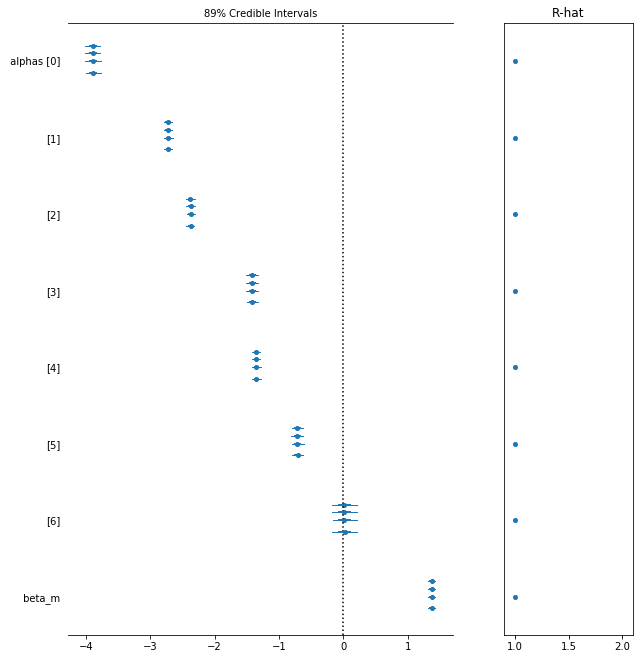

In [0]:
plt.figure(figsize=(10,10))
pm.forestplot(parta_trace, varnames=['alphas', 'beta_m'], alpha=.11)


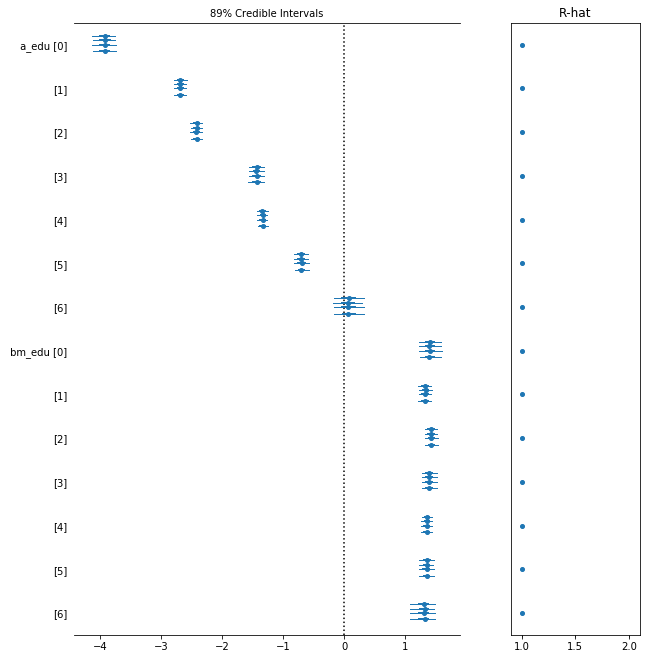

In [0]:
plt.figure(figsize=(10,10))
pm.forestplot(partb_trace, varnames=['a_edu', 'bm_edu'], alpha=.11)

**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 3 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\].

### answer

The posterior probability that males with a Bachelor's degree was approximately 0.50. The posterior probability that males with a Professional School degree (education categories 3 and 4) was 0.27 and 0.49 respectively. Looking at the posterior mean, the conclusion seems to be true. However, factoring the standard error of the posterior probabilities we see the difference of category 4 and category 5 are negligible, because the standard error of category 4 is quite high with 0.012 ($0.489 + 0.012 \approx 0.50$). 

2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples


### answer

The posterior-predictive on the number of female PhDs earning more than 50K in the identically sized samples (86) was 43.90 with the standard error of 5.4. This suggests a shrinkage effect due to pooling and that female phd students do not likely have as much income as the data alone may suggest (50/86). 

In [0]:
posterior_mean = partb_trace["p"].mean(axis=0)
posterior_std = partb_trace["p"].std(axis=0)

#posterior_mean[ 4, 5, 6, 7]


"""
cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']
"""


# category 3, 4
print("cat 5")
print(posterior_mean[9], posterior_std[9])

print("cat 3")
print(posterior_mean[5], posterior_std[5])

print("cat 4")
print(posterior_mean[7], posterior_std[7])

cat 5
0.504179023499 0.00788691453521
cat 3
0.270530813167 0.00592609860846
cat 4
0.48997988336 0.0124641018591


In [0]:
with partb_model:
    partb_ppc = pm.sample_ppc(partb_trace, samples=86)

100%|██████████| 86/86 [00:00<00:00, 3877.77it/s]


In [0]:
partb_ppc["income"][:, 12].mean(), partb_ppc["income"][:, 12].std(), y_obs[12]

(43.906976744186046, 5.4080644067324268, 50)

In [0]:
def plot_post_validation_check(ax, above_50k, total, ppc_obs, labels, title=""):
    
    color_map = plt.cm.get_cmap("viridis")
    upper_quantile = np.percentile(ppc_obs, 89, axis=0)
    lower_quantile = np.percentile(ppc_obs, 11, axis=0)

    for i in range(0, 7):
        ax.plot([2*i], (above_50k/ total)[2*i], color= 'darkred', alpha=0.4, marker='H', linestyle='None')
        ax.plot([2*i+1], (above_50k/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='H', linestyle='None')

        ax.plot([2*i, 2*i+1], (above_50k/ total)[2*i:2*i+2], color = color_map(2/7), linestyle='-')
        
        ax.text(2*i+ 0.6, np.mean((above_50k/total)[2*i:2*i+2]), labels[i],  color = color_map(2/7), ha='left', va='top')
        
        # plot ppc means
        ax.plot([2*i], (ppc_obs.mean(axis=0)/ total)[2*i], color= 'darkred', alpha=0.4, marker='*', linestyle='None')
        ax.plot([2*i+1], (ppc_obs.mean(axis=0)/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='*', linestyle='None')

        
        # plot percentiles
        ax.plot([2*i], (upper_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i], (lower_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='v', linestyle='None')

        ax.plot([2*i+1], (upper_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i+1], (lower_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='v', linestyle='None')
        
        
        

    ax.set_xlim((-0.5, 13.5))
    ax.set_ylim((0, 1))
    ax.set_title("Posterior Validation Check - " + title)
    ax.set_ylabel("Proportion > \$50k")

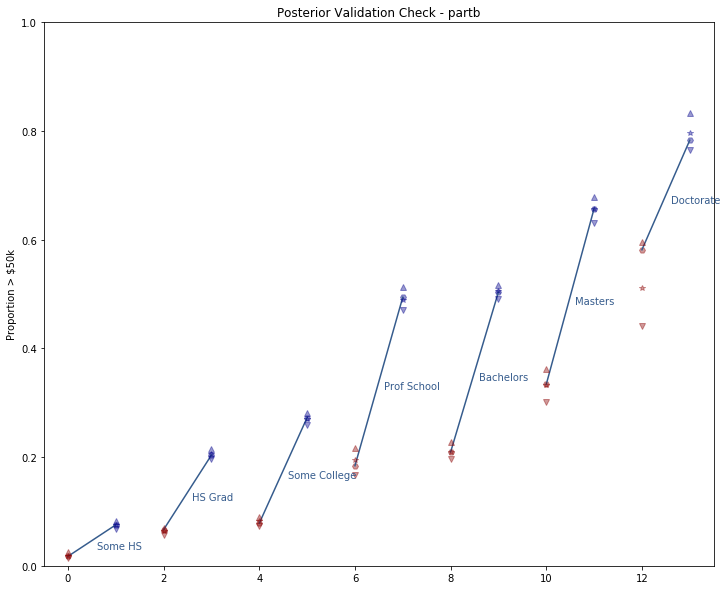

In [0]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_post_validation_check(ax, y_obs, n, partb_ppc["income"], labels, "partb")

# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv("one-to-many.csv")
df.head()

,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

**A1** Implement this algorithm along with a convergence criterion of your choice

### answer
The algorithm hsa been implemented using scikit's linear regression package. The convergence criteria is when there's no change in the cluster assignment between two consecutive iterations.

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging. 

### answer
The diagrams are shown below: the given data and the predictions. We can see the lines have fit the training data well. The quality of convergence is sensitive to the initialization. It converged after 8 steps.


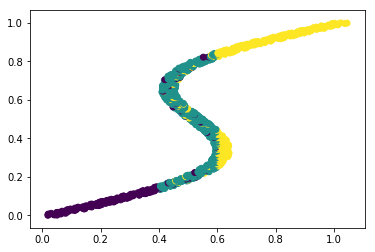

In [0]:
x = np.array(df.x.tolist())
y = np.array(df.target.tolist())
# cluster the data
n = len(x)
z = np.zeros(n, dtype=np.int)
z[x <= 0.4] = 0
z[x >= 0.6] = 2
n_mid = len(z[(0.4 < x) & (x < 0.6)])
p = [0.05, 0.9, 0.05]
z[(0.4 < x) & (x < 0.6)] = np.random.choice(range(3), p=p, size=n_mid)
plt.scatter(x, y, c=z)

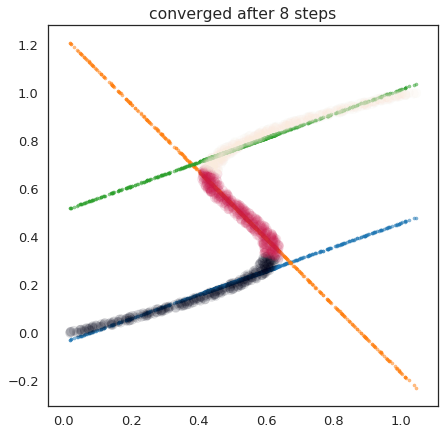

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import itertools
# fit iteratively

t = 0
for t in itertools.count():
    z_old = z
    
    m1 = linear_model.LinearRegression()
    m2 = linear_model.LinearRegression()
    m3 = linear_model.LinearRegression()
    
    models = [m1, m2, m3]

    z1_indices = np.argwhere(z == 0)
    z2_indices = np.argwhere(z == 1)
    z3_indices = np.argwhere(z == 2)

    z1_x = x[z1_indices] 
    z1_y = y[z1_indices] 
    
    z2_x = x[z2_indices] 
    z2_y = y[z2_indices] 
    
    z3_x = x[z3_indices] 
    z3_y = y[z3_indices]
    
    m1.fit(z1_x, z1_y)
    m2.fit(z2_x, z2_y)
    m3.fit(z3_x, z3_y)
    
    y_hat_m1 = m1.predict(np.vstack(x))
    y_hat_m2 = m2.predict(np.vstack(x))
    y_hat_m3 = m3.predict(np.vstack(x))
    
    
    d1 = np.power(y - y_hat_m1.flatten(), 2)
    d2 = np.power(y - y_hat_m2.flatten(), 2)
    d3 = np.power(y - y_hat_m3.flatten(), 2)
    M = np.vstack((d1, d2, d3))
    z = M.argmin(axis=0)
    
    if np.all(z_old == z):
        fig = plt.figure(figsize=(7,7))
        plt.title("converged after {} steps".format(t + 1))
        plt.scatter(x, y_hat_m1, alpha=0.5, s=10.0)
        plt.scatter(x, y_hat_m2, alpha=0.5, s=10.0)
        plt.scatter(x, y_hat_m3, alpha=0.5, s=10.0)
        plt.scatter(x, y, c=z, alpha=0.1)
        plt.show()
        break


## Part B: Variational Mixture of Experts


**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)


### answer
A pymc3 model for this problem has been implemented as below. 

In [0]:
D_x = np.vstack(x)
D_y = np.vstack(y)

In [0]:
with pm.Model() as p2_partb_model:
    prob_bias = pm.Normal("pb", mu=0, sd=5, shape=(3,))
    prob_weights = pm.Normal("pw", mu=0, sd=5, shape=(1,3))
    prob_affine = pm.math.dot(D_x, prob_weights) + prob_bias
    
    mu_bias = pm.Normal("mb", mu=0, sd=5, shape=(3,) )
    mu_weights = pm.Normal("mw", mu=0, sd=5, shape=(1,3))
    mu_affine = pm.math.dot(D_x, mu_weights) + mu_bias

    logsd_bias = pm.Normal("sdb", mu=0, sd=5, shape=(3,) )
    logsd_weights = pm.Normal("sdw", mu=0, sd=5, shape=(1,3))
    logsd_affine = pm.math.dot(D_x, logsd_weights) + logsd_bias
    
    prob = pm.Deterministic("prob", tt.nnet.softmax(prob_affine))
    mu = pm.Deterministic("mu", mu_affine)
    sd = pm.Deterministic("sd", tt.exp(logsd_affine) + 0.01)
    
    #nm = pm.NormalMixture('nm', w=prob, mu=mu, sd=sd, observed=D_y)
    nm = pm.NormalMixture('nm', w=prob, mu=mu, sd=sd, observed=D_y)


**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.


### answer
Using ADVI and an adam optimizer, we sampled variationally as below. The ELBO has been plotted

In [0]:
with p2_partb_model:
    inference = pm.ADVI()
    h = pm.fit(method=inference, n=50000, obj_optimizer=pm.adam())
    p2_partb_trace = h.sample(draws=5000)


Average Loss = -1,602.8: 100%|██████████| 50000/50000 [00:45<00:00, 1102.53it/s]
Finished [100%]: Average Loss = -1,602.8


In [0]:
ss = pm.summary(p2_partb_trace, varnames=["pb", "pw", "mb", "mw", "sdb", "sdw"])
ss

,mean,sd,mc_error,hpd_2.5,hpd_97.5
pb__0,-4.892629,0.085715,0.001105,-5.060262,-4.723305
pb__1,4.509217,0.087461,0.001051,4.335576,4.677009
pb__2,0.565488,0.069567,0.000908,0.439435,0.709551
pw__0_0,8.449249,0.139442,0.002024,8.182344,8.726852
pw__0_1,-9.705199,0.184952,0.002509,-10.056540,-9.331426
pw__0_2,-0.179823,0.129929,0.001807,-0.421999,0.082253
mb__0,0.574729,0.000821,0.000011,0.573051,0.576295
mb__1,-0.020154,0.000773,0.000011,-0.021644,-0.018644
mb__2,1.331699,0.002071,0.000032,1.327600,1.335739
mw__0_0,0.426207,0.000959,0.000013,0.424357,0.428104


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05b7e0fb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f058cea6278>]], dtype=object)

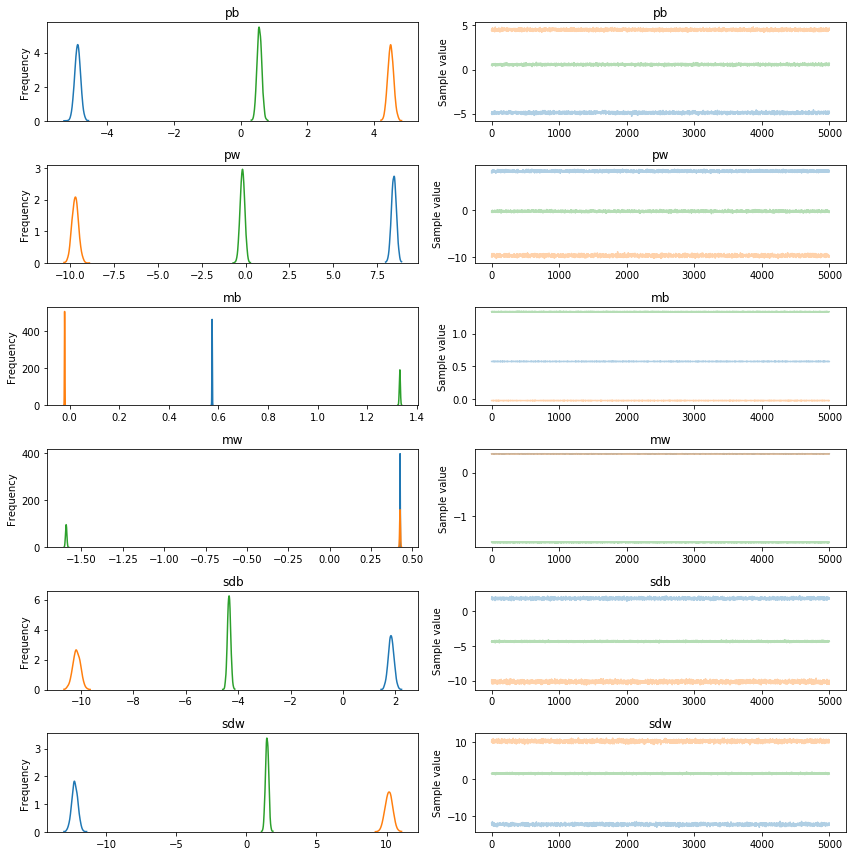

In [0]:
pm.traceplot(p2_partb_trace, varnames=["pb", "pw", "mb", "mw", "sdb", "sdw"], combined=True)

Text(0.5,0,'iteration')

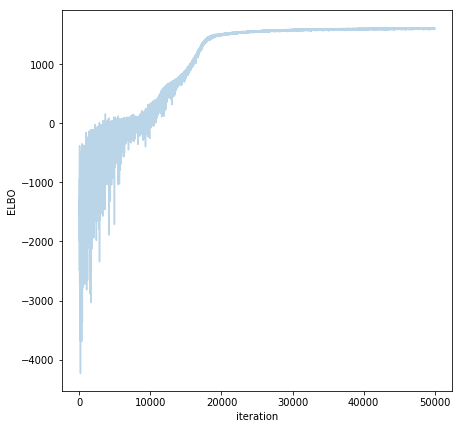

In [0]:
plt.figure(figsize=(7,7))
plt.plot(-h.hist, alpha=0.3)
plt.ylabel('ELBO')
plt.xlabel('iteration')

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

### answer


In [0]:
p2_partb_pm_mu = p2_partb_trace["mu"].mean(axis=0)
p2_partb_pm_sd = p2_partb_trace["sd"].mean(axis=0)
p2_partb_pm_prob = p2_partb_trace["prob"].mean(axis=0)

mu0 = p2_partb_pm_mu[:, 0]
mu1 = p2_partb_pm_mu[:, 1]
mu2 = p2_partb_pm_mu[:, 2]

sd0 = p2_partb_pm_sd[:, 0]
sd1 = p2_partb_pm_sd[:, 1]
sd2 = p2_partb_pm_sd[:, 2]


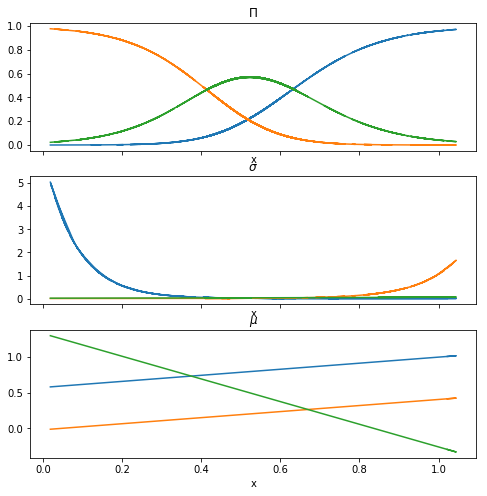

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x, p2_partb_pm_prob)
ax1.set_xlabel("x")
ax1.set_title('$\Pi$')

ax2.plot(x, p2_partb_pm_sd)
ax2.set_xlabel("x")
ax2.set_title('$\sigma$')

ax3.plot(x, p2_partb_pm_mu)
ax3.set_title('$\mu$')
ax3.set_xlabel("x")

plt.show()


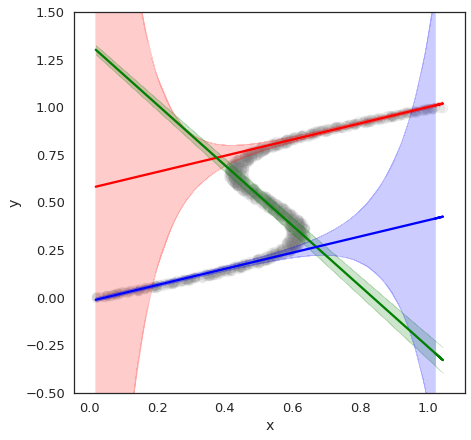

In [0]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(x, y, c="grey", alpha=0.1)
ax.plot(x, mu0, c="r")
ax.fill_between(x, mu0-sd0, mu0+sd0, color="r", alpha=0.2)

ax.plot(x, mu1, c="g")
ax.fill_between(x, mu1-sd1, mu1+sd1, color="g", alpha=0.2)

ax.plot(x, mu2, c="b")
ax.fill_between(x, mu2-sd2, mu2+sd2, color="b", alpha=0.2)

ax.set_ylim([-0.5, 1.5])
plt.show()

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

### answer

The posterior predictive has been plotted. It looks very different from the data because we are predicting deterministically one value for each x with $\mathrm{argmax}$. In addition, for the regions where the data points  came from one cluster only, the predictions are not accurate. This is because the model is not considering  the cluster from which each data point came from. Instead it takes a weighted average of all of the clusters/models. To remedy this, we want the predictions to vary according to the gating function with softmax as implemented in B5.


In [0]:
with p2_partb_model:
    p2_partb_ppc = pm.sample_ppc(p2_partb_trace, samples=5000)

100%|██████████| 5000/5000 [01:32<00:00, 54.14it/s]


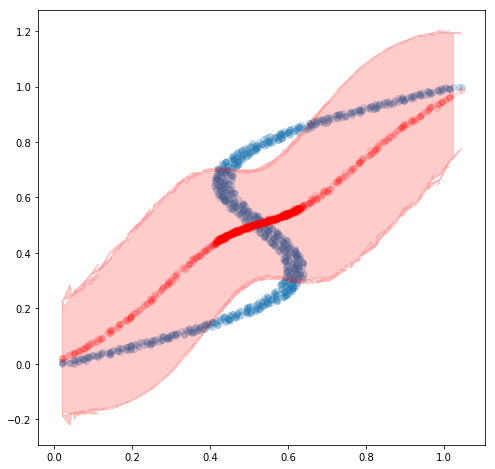

In [0]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2)
y_hat = p2_partb_ppc["nm"].mean(axis=0)
y_hat_se = p2_partb_ppc["nm"].std(axis=0)
plt.fill_between(x, y_hat - y_hat_se, y_hat + y_hat_se, alpha=0.2, color="r")
plt.scatter(x, y_hat, alpha=0.1, c="r")
plt.show()

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

### answer
The diagram has been plotted as below. We see the fit is better than in B4 except the points scatter in the middle range. 

In [0]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

prob_data = p2_partb_trace["prob"].mean(axis=0)
sigma_data = p2_partb_trace["sd"].mean(axis=0)
mu_data = p2_partb_trace["mu"].mean(axis=0)


k = gumbel_sample(prob_data)
n_samples = 1000
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

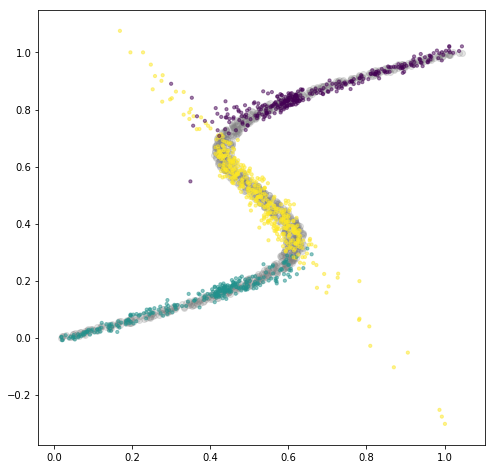

In [0]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2, c="grey")
plt.scatter(x, sampled, c=k, alpha=0.5, s=10.0)
plt.show()

## Part C. Mixture Density Network


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
from torch.nn.utils import clip_grad_norm
import torchvision.transforms as transforms

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.


### answer

The model has been implemented. The number of hidden layers can be varied. The forward funcion was implemented.

In [0]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_hidden_layer, n_gaussians):
        super(MDN, self).__init__()
        
        
        m = nn.Sequential()
    
        m.add_module("fc_0", nn.Linear(1, n_hidden))
        m.add_module("act_0", nn.Tanh())
        for i in range(n_hidden_layer - 1):
            m.add_module("fc_{}".format(i+1), nn.Linear(1, n_hidden))
            m.add_module("act_{}".format(i+1), nn.Tanh())
        
        
        self.z_h = m
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        #sigma = torch.exp(self.z_sigma(z_h)) + Variable([0.01])
        sigma = torch.exp(self.z_sigma(z_h)) + 0.01
        mu = self.z_mu(z_h)
        return pi, sigma, mu
    
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)




**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.


### answer

The model has been trained for 100000 epochs. We see the convergence of loss.


In [0]:
network = MDN(n_hidden=20, n_hidden_layer=1, n_gaussians=3)
optimizer = torch.optim.Adam(network.parameters())

x_tensor = torch.from_numpy(np.float32(x).reshape(1000, 1))
y_tensor = torch.from_numpy(np.float32(y).reshape(1000, 1))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor)
def train_mdn(n_epoch=10000):
    loss_list = []
    for epoch in range(n_epoch):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data[0])

        #if epoch % 500 == 0:
            #print(epoch, loss.data[0])
    return loss_list
loss_list = train_mdn(n_epoch=100000)



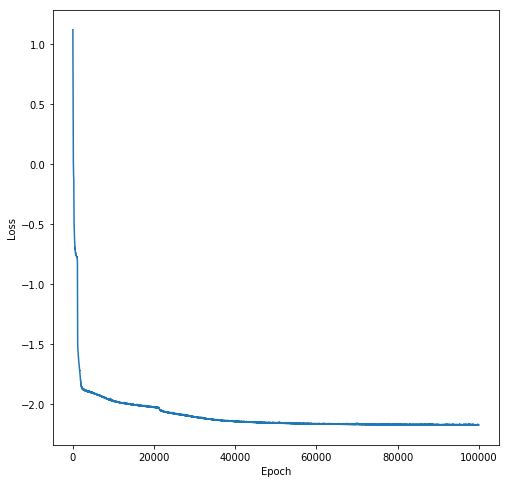

In [0]:
plt.figure(figsize=(8, 8))
plt.plot(range(len(loss_list)), loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

### answer

We show the MLE parameters for $\mu, \sigma, \pi$ separately against $x$. We also show a plot similar to B3. We see the fit is fairly good but still see some bad predictions. To address the issue, we improve with gumbel sampling in B5. 

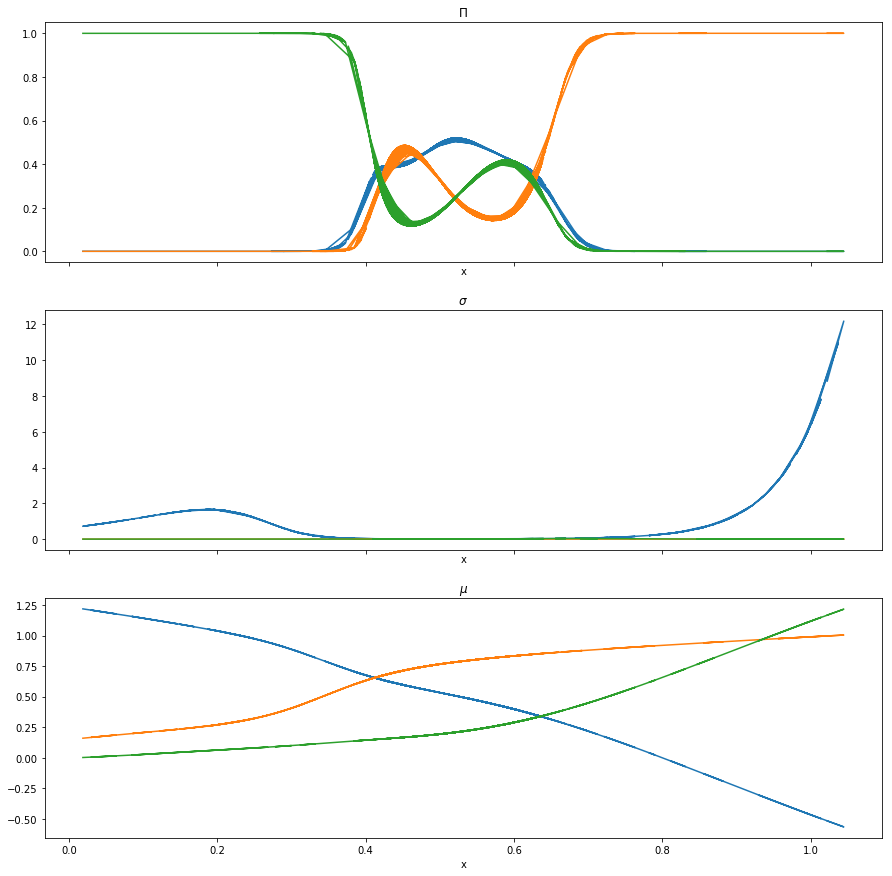

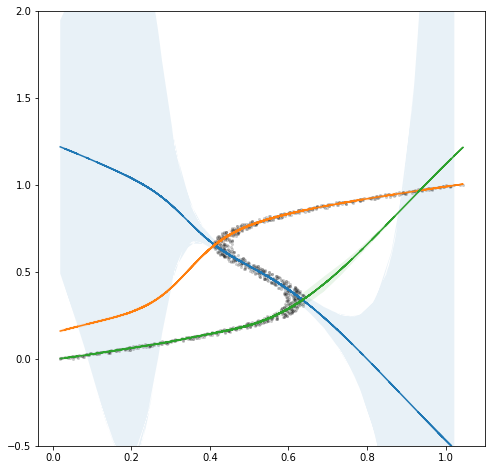

In [0]:
pi_variable, sigma_variable, mu_variable = network(x_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.plot(x, pi_data)
ax1.set_xlabel("x")
ax1.set_title('$\Pi$')

ax2.plot(x, sigma_data)
ax2.set_xlabel("x")
ax2.set_title('$\sigma$')

ax3.plot(x, mu_data)
ax3.set_title('$\mu$')
ax3.set_xlabel("x")

plt.show()

plt.figure(figsize=(8, 8), facecolor='white')
plt.ylim([-0.5, 2])
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x, mu_k)
    plt.fill_between(x, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()


**C4**: Sample from the sampling distributions to make a plot similar to B5 above

**To think about but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

### answer

Sampling from gumbel has been plotted as below. We see a much better fit than any of other plots. The main difference is that MDN has a shared network and maps the input data to the feature space in the same way for all of its three outputs. Assuming the bottleneck (compressed input/activation of the tanh) is informative, the feature space (after activation) becomes of lower dimension and therefore likely became easier to fit $\mu, \sigma, \pi$. In MoE, the raw input is directly fed into for the three channels and the benefit described may not exist. If the hidden layer is taken out, the quality of the fitting of part C would likely drop and may be similar to B.

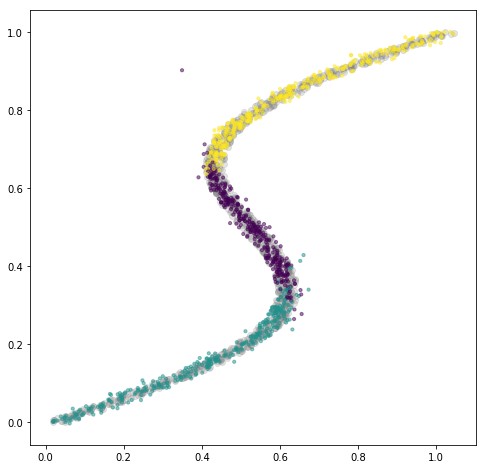

In [0]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2, c="grey")
plt.scatter(x, sampled, c=k, alpha=0.5, s=10.0)
plt.show()


## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.


### answer

The equivalent pymc3 model has been implemented. 

In [0]:
import theano.tensor as T
import theano

In [0]:
n_hidden = 20
with pm.Model() as vmdn_model:
    b1 = pm.Normal("b1", mu=0, sd=5, shape=(1,))
    w1 = pm.Normal("w1", mu=0, sd=5, shape=(1, n_hidden))
    z1 = T.tanh(pm.math.dot(D_x, w1) + b1)

    prob_bias = pm.Normal("pb", mu=0, sd=5, shape=(3,))
    prob_weights = pm.Normal("pw", mu=0, sd=5, shape=(n_hidden,3))
    prob_affine = pm.math.dot(z1, prob_weights) + prob_bias
    
    mu_bias = pm.Normal("mb", mu=0, sd=5, shape=(3,) )
    mu_weights = pm.Normal("mw", mu=0, sd=5, shape=(n_hidden,3))
    mu_affine = pm.math.dot(z1, mu_weights) + mu_bias

    logsd_bias = pm.Normal("sdb", mu=0, sd=5, shape=(3,) )
    logsd_weights = pm.Normal("sdw", mu=0, sd=5, shape=(n_hidden,3))
    logsd_affine = pm.math.dot(z1, logsd_weights) + logsd_bias
    
    prob = pm.Deterministic("prob", tt.nnet.softmax(prob_affine))
    mu = pm.Deterministic("mu", mu_affine)
    sd = pm.Deterministic("sd", tt.exp(logsd_affine) + 0.01)
    
    nm = pm.NormalMixture('nm', w=prob, mu=mu, sd=sd, observed=D_y)



**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

### answer

The posterior predictive has been plotted.  We see convergence. The quality of posterior predictive is not as good as in part C, and slightly better than in part B. 

In [0]:
with vmdn_model:
    inference = pm.ADVI()
    vdmn_h = pm.fit(method=inference, n=120000, obj_optimizer=pm.adam(learning_rate=0.0005))


Average Loss = -1,190.8: 100%|██████████| 120000/120000 [05:34<00:00, 358.63it/s]
Finished [100%]: Average Loss = -1,190.4


In [0]:
with vmdn_model:
    vmdn_trace = vdmn_h.sample(draws=5000)
    

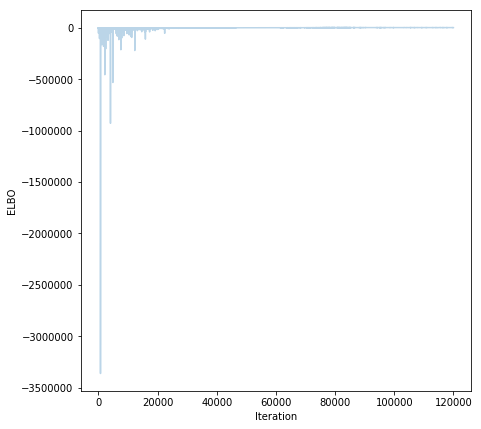

In [0]:
plt.figure(figsize=(7,7))
plt.plot(-vdmn_h.hist, alpha=0.3)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.show()

In [0]:
with vmdn_model:
    vmdn_ppc = pm.sample_ppc(vmdn_trace, samples=5000)

100%|██████████| 5000/5000 [02:32<00:00, 32.72it/s]


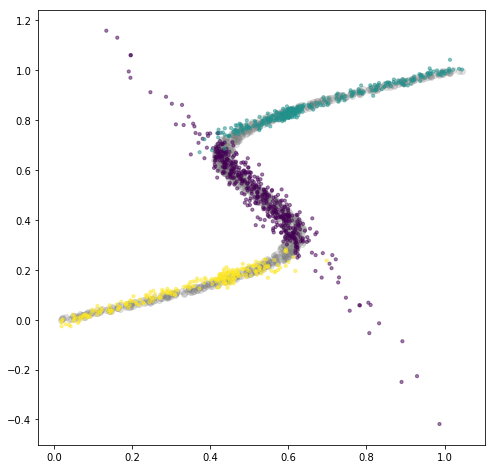

In [0]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

prob_data = vmdn_trace["prob"].mean(axis=0)
sigma_data = vmdn_trace["sd"].mean(axis=0)
mu_data = vmdn_trace["mu"].mean(axis=0)


k = gumbel_sample(prob_data)
n_samples = 1000
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2, c="grey")
plt.scatter(x, sampled, c=k, alpha=0.5, s=10.0)
plt.show()

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?


### answer

The mean regressed curves have been plotted below. They look different and the part C model shows a better fit with the regressed means looking more curved than in the part D model. They have the same model, except the inference is variational in part D. The difference seems to have been caused by the fact the part D model got stuck at a local minimum and that the weight initialization for the part C model is better conditioned (pytorch's default). This is expected because likelihood function is in generally non-convex with multiple local optima. Though Gaussian belongs to the exponential family where the complete data log likelihood is convex, provided we can observe the latent data $k$ directly. However, in our case, we do not observe $k$.   

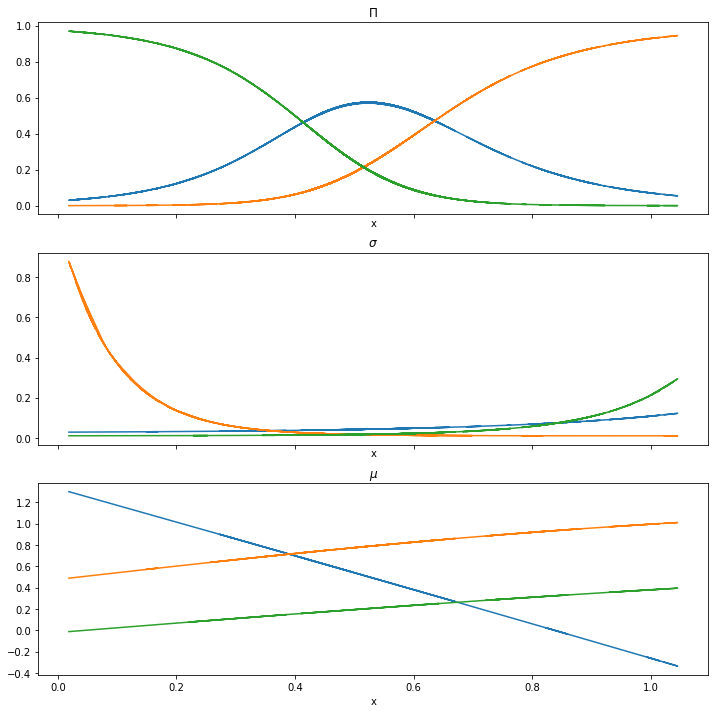

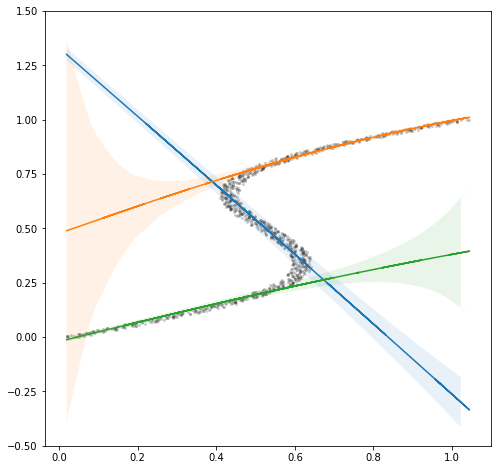

In [0]:
vmdn_mu = vmdn_trace["mu"].mean(axis=0)
vmdn_sd = vmdn_trace["sd"].mean(axis=0)
vmdn_prob = vmdn_trace["prob"].mean(axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12))
ax1.plot(x, vmdn_prob)
ax1.set_xlabel("x")
ax1.set_title('$\Pi$')

ax2.plot(x, vmdn_sd)
ax2.set_xlabel("x")
ax2.set_title('$\sigma$')

ax3.plot(x, vmdn_mu)
ax3.set_title('$\mu$')
ax3.set_xlabel("x")

plt.show()


plt.figure(figsize=(8, 8), facecolor='white')
plt.ylim([-0.5, 1.5])
for mu_k, sigma_k in zip(vmdn_mu.T, vmdn_sd.T):
    plt.plot(x, mu_k)
    plt.fill_between(x, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()


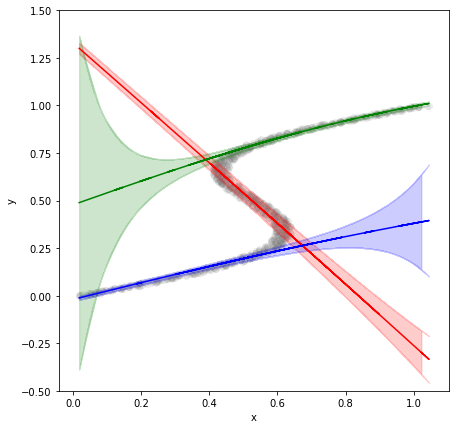

In [0]:
mu0 = vmdn_mu[:, 0]
mu1 = vmdn_mu[:, 1]
mu2 = vmdn_mu[:, 2]

sd0 = vmdn_sd[:, 0]
sd1 = vmdn_sd[:, 1]
sd2 = vmdn_sd[:, 2]


fig = plt.figure(figsize=(7,7))

ax = plt.gca()
ax.set_ylim([-0.5, 1.5])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(x, y, c="grey", alpha=0.1)
ax.plot(x, mu0, c="r")
ax.fill_between(x, mu0-sd0, mu0+sd0, color="r", alpha=0.2)

ax.plot(x, mu1, c="g")
ax.fill_between(x, mu1-sd1, mu1+sd1, color="g", alpha=0.2)

ax.plot(x, mu2, c="b")
ax.fill_between(x, mu2-sd2, mu2+sd2, color="b", alpha=0.2)

plt.show()

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)